In [1]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import SnowballStemmer
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import re
import string
import nltk
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, kendalltau
import jieba

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Data Importing and Sorting

In [3]:
files = os.listdir('corpus')
files.remove('.DS_Store')
files.remove('scores_ru-en.csv')
scaler = MinMaxScaler()
for file_ in files:
  name = file_.split('-')[0] + file_.split('-')[1]
  vars()[name] = pd.read_csv(os.path.join('corpus', file_, 'scores.csv'))
  vars()[name].drop(columns = ['source', 'annotators', 'avg-score'], inplace = True)
  vars()[name]['z-score'] = scaler.fit_transform(vars()[name]['z-score'].values.reshape(-1,1)) #normalizing values betwewen 0 and 1

In [4]:
english = csen.copy()
for df in [deen, ruen, zhen]:
  english = english.append(df)

In [5]:
finnish = enfi.copy()
chinese = enzh.copy()

In [6]:
english.reset_index(drop = True, inplace = True)

# Baseline assessment before preprocessment

### Finnish & Chinese

Splitting the data for the finnish and chinese for baseline correlation assessment purposes

In [7]:
# Train, Validation & Test split
# en_train, en_dev = train_test_split(english, shuffle = True, test_size = 0.2, random_state = 7)
# en_dev, en_test = train_test_split(en_dev, shuffle = True, test_size = 0.5, random_state = 7)

fin_train, fin_dev = train_test_split(finnish, shuffle = True, test_size = 0.2, random_state = 7)
fin_dev, fin_test = train_test_split(fin_dev, shuffle = True, test_size = 0.5, random_state = 7)

ch_train, ch_dev = train_test_split(chinese, shuffle = True, test_size = 0.2, random_state = 7)
ch_dev, ch_test = train_test_split(ch_dev, shuffle = True, test_size = 0.5, random_state = 7)

Define functions that preprocess the data and compute the correlation values for the baseline

In [8]:
def dataVectorization(train, dev, test):
    """
    Function that receives train, development and test datasets and returns the sets vectorized.
    
    """    
    # Create the CountVectorizer (Bag of words) object
    baseline_encoder = CountVectorizer(max_features = 5000) # Settting limit for computational reasons
    
    train_vectorizer_reference = baseline_encoder.fit_transform(train['reference']).todense()
    train_vectorizer_translation = baseline_encoder.transform(train['translation']).todense()
    train_vectorizer = [train_vectorizer_reference, train_vectorizer_translation]
    
    for i, d in enumerate([dev, test]):
        referece_vectorized = baseline_encoder.transform(d['reference']).todense()
        translation_vectorized = baseline_encoder.transform(d['translation']).todense()
        if i == 0:
            dev_vectorizer = [referece_vectorized, translation_vectorized]
        else:
            test_vectorizer = [referece_vectorized, translation_vectorized]
    
    return train_vectorizer, dev_vectorizer, test_vectorizer

def getBaseline(reference, translation, yLabels):
    """
    Get baseline correlations for the given sets, computing the cosine similarity.
    
    """   
    cos = []
    for i in range(reference.shape[0]):
        cos.append(cosine_similarity(reference[i], translation[i])[0])
    cos = np.array(cos)
    cos.shape = (cos.shape[0],)
    
    return pearsonr(yLabels, cos), kendalltau(yLabels, cos)

In [9]:
fin_train_bl_encoded, fin_dev_bl_encoded, fin_test_bl_encoded = dataVectorization(fin_train, fin_dev, fin_test)
ch_train_bl_encoded, ch_dev_bl_encoded, ch_test_bl_encoded = dataVectorization(ch_train, ch_dev, ch_test)

Get the correlations for both datasets (Finnish & Cinese; Train & Development)

In [10]:
# Finnish
y_train_label = np.array(fin_train['z-score'])
finnish_train_pearson, finnish_train_kendalltau = getBaseline(fin_train_bl_encoded[0], fin_train_bl_encoded[1], y_train_label)
print(f'Finnish - Pearson correlation between cosine similarity and score on train set: {finnish_train_pearson[0]} (p-value < 0.001: {finnish_train_pearson[1] < 0.001}); and Kendall Tau: {finnish_train_kendalltau[0]} (p-value < 0.001: {finnish_train_kendalltau[1] < 0.001})')
y_dev_label = np.array(fin_dev['z-score'])
finnish_dev_pearson, finnish_dev_kendalltau = getBaseline(fin_dev_bl_encoded[0], fin_dev_bl_encoded[1], y_dev_label)
print(f'Finnish - Pearson correlation between cosine similarity and score on validation set: {finnish_dev_pearson[0]} (p-value < 0.001: {finnish_dev_pearson[1] < 0.001}); and Kendall Tau: {finnish_train_kendalltau[0]} (p-value < 0.001: {finnish_train_kendalltau[1] < 0.001})')

# Chinese
y_train_label = np.array(ch_train['z-score'])
chinese_train_pearson, chinese_train_kendalltau = getBaseline(ch_train_bl_encoded[0], ch_train_bl_encoded[1], y_train_label)
print(f'Chinese - Pearson correlation between cosine similarity and score on train set: {chinese_train_pearson[0]} (p-value < 0.001: {chinese_train_pearson[1] < 0.001}); and Kendall Tau: {chinese_train_kendalltau[0]} (p-value < 0.001: {chinese_train_kendalltau[1] < 0.001})')
y_dev_label = np.array(ch_dev['z-score'])
chinese_dev_pearson, chinese_dev_kendalltau = getBaseline(ch_dev_bl_encoded[0], ch_dev_bl_encoded[1], y_dev_label)
print(f'Chinese - Pearson correlation between cosine similarity and score on validation set: {chinese_dev_pearson[0]} (p-value < 0.001: {chinese_dev_pearson[1] < 0.001}); and Kendall Tau: {chinese_train_kendalltau[0]} (p-value < 0.001: {chinese_train_kendalltau[1] < 0.001})')

Finnish - Pearson correlation between cosine similarity and score on train set: 0.4683911953347246 (p-value < 0.001: True); and Kendall Tau: 0.3000391460359087 (p-value < 0.001: True)
Finnish - Pearson correlation between cosine similarity and score on validation set: 0.4849728233340249 (p-value < 0.001: True); and Kendall Tau: 0.3000391460359087 (p-value < 0.001: True)
Chinese - Pearson correlation between cosine similarity and score on train set: 0.14739166396153264 (p-value < 0.001: True); and Kendall Tau: 0.12438157343879563 (p-value < 0.001: True)
Chinese - Pearson correlation between cosine similarity and score on validation set: 0.08052579663476413 (p-value < 0.001: False); and Kendall Tau: 0.12438157343879563 (p-value < 0.001: True)


# Cleaning the corpus

In [11]:
def clean(text_list,
          lower = False,
          keep_numbers = False,
          keep_expression = False,
          remove_char = False,
          remove_stop = False,
          remove_tag = False,
          lemmatize = False,
          stemmer = False,
          english = True
          ):
    """
    Function that a receives a list of strings and preprocesses it.
    
    :param text_list: List of strings.
    :param lemmatize: Tag to apply lemmatization if True.
    :param stemmer: Tag to apply the stemmer if True.
    """
    if english:
        lang = 'english'
    else:
        lang = 'finnish'
    
    stop = set(stopwords.words(lang))
    stem = SnowballStemmer(lang)
    
    updates = []
    for j in range(len(text_list)):
        
        text = text_list[j]
        
        #LOWERCASE TEXT
        if lower:
            text = text.lower()
            
        #KEEP NUMBERS AS TOKENS
        if not keep_numbers:
            text = re.sub("[\d+]", 'X', text)
        
        #KEEP '?' and '!' AS TOKENS
        if not keep_expression:
            text = re.sub("[\?|\!]", 'EXPRESSION', text)
            
        #REMOVE TAGS
        if remove_tag:
            text = BeautifulSoup(text).get_text()
            
        #REMOVE THAT IS NOT TEXT
        if remove_char:
            text = re.sub("[^a-zA-Z]", ' ', text)
        
        #REMOVE STOP WORDS
        if remove_stop:
            text = ' '.join([word for word in text.split(' ') if word not in stop])
        
        #LEMMATIZATION
        if lemmatize:
            if english:
                lemma = WordNetLemmatizer()
                text = " ".join(lemma.lemmatize(word) for word in text.split())
        
        #STEMMER
        if stemmer:
            text = " ".join(stem.stem(word) for word in text.split())
        
        updates.append(text)
        
    return updates

def clean_ch(text_list, keep_numbers=False, remove_punctuation=False, remove_stop = False, stopwords_set='merged'):
    """
    Function that removes chinese stopwords
    
    :param stopwords_set: remove words of both sets (merged), just the 1st (fst) or just the second (snd) 
    """
    updates = []
    
    zh_stopwords1 = [line.strip() for line in open('chinese_stopwords/chinese_stopwords1.txt', 'r', encoding='utf-8').readlines()]
    zh_stopwords2 = [line.strip() for line in open('chinese_stopwords/chinese_stopwords2.txt', 'r', encoding='utf-8').readlines()]
    
    if stopwords_set == 'merged':
        stop = list(set(zh_stopwords1 + zh_stopwords2))
    elif stopwords_set == 'fst':
        stop = zh_stopwords1
    elif stopwords_set == 'snd':
        stop = zh_stopwords2

    for j in range(len(text_list)):
        
        text = text_list[j]
        
        #KEEP NUMBERS AS TOKENS
        if keep_numbers:
            text = re.sub("[\d+]", 'X', text)
        
        # REMOVE PUNCTUATION
        if remove_punctuation:
            # https://stackoverflow.com/questions/36640587/how-to-remove-chinese-punctuation-in-python
            punc = "！？｡。＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏."
            text = re.sub(r"[%s]+" %punc, "", text)
        
        # REMOVE STOP WORDS
        if remove_stop:
            pretext = text
            text = ' '.join([word for word in jieba.cut(text) if word not in stop])
            
        updates.append(text)
        
    return updates

In [12]:
finnish_cleaned = pd.DataFrame()
finnish_cleaned['z-score'] = finnish['z-score']
for column in ['reference', 'translation']:
    finnish_cleaned[column] = clean(finnish[column], lower = True)
finnish_cleaned.head()

,z-score,reference,translation
0,0.414391,"voit muuttaa itsesi ananasta, koirasta tai roy...","voit muuttaa itsesi ananakseksi, koiraksi tai ..."
1,0.604674,myös ammuttiin kolme miestä: kaksi XX-vuotiait...,myös kolmea miestä ammuttiin: kahta XX-vuotias...
2,0.736070,tiedot tallennetaan kassakoneisiin joka tapauk...,tiedot kuitenkin tallentuvat kassoilla joka ta...
3,0.567227,"xinhua kertoo, että xinyin näytteestä oli sunn...","xinhua kertoo, että xinyin sunnuntaina antamas..."
4,0.367150,voitaisiin kuulla cbd: n kommenttitiimin toimi...,"macdonaldin, joka tuli cbc:n selostajatiimiin ..."


In [13]:
parameters = {'lower': [True, False],
              'keep_numbers': [True, False],
              'keep_expression': [True, False],
              'remove_char': [True, False],
              'remove_stop': [True, False],
              'remove_tag': [True, False],
              'lemmatize': [False],
              'stemmer': [True, False]}

parameters = pd.DataFrame(list(ParameterGrid(parameters)))

In [14]:
for conf in range(parameters.shape[0]):
    sets = ['train', 'dev']
    cleaned_data = pd.DataFrame()
    cleaned_data['z-score'] = finnish['z-score']
    for column in ['reference', 'translation']:
        cleaned_data[column] = clean(finnish[column],
                                    lower = parameters.loc[conf, 'lower'],
                                    keep_numbers = parameters.loc[conf, 'keep_numbers'],
                                    keep_expression = parameters.loc[conf, 'keep_expression'],
                                    remove_char = parameters.loc[conf, 'remove_char'],
                                    remove_stop = parameters.loc[conf, 'remove_stop'],
                                    remove_tag = parameters.loc[conf, 'remove_tag'],
                                    lemmatize = parameters.loc[conf, 'lemmatize'],
                                    stemmer = parameters.loc[conf, 'stemmer'],
                                    english=False)
    
    fin_train, fin_dev = train_test_split(cleaned_data, shuffle = True, test_size = 0.2, random_state = 7)
    fin_dev, fin_test = train_test_split(fin_dev, shuffle = True, test_size = 0.5, random_state = 7)
    
    fin_train_bl_encoded, fin_dev_bl_encoded, fin_test_bl_encoded = dataVectorization(fin_train, fin_dev, fin_test)
    
    y_train_label = np.array(fin_train['z-score'])
    finnish_train_pearson, finnish_train_kendalltau = getBaseline(fin_train_bl_encoded[0], fin_train_bl_encoded[1], y_train_label)
    parameters.loc[conf, ['pearson_train', 'kendal_train']] = finnish_train_pearson[0], finnish_train_kendalltau[0]
    
    y_dev_label = np.array(fin_dev['z-score'])
    finnish_dev_pearson, finnish_dev_kendalltau = getBaseline(fin_dev_bl_encoded[0], fin_dev_bl_encoded[1], y_dev_label)
    parameters.loc[conf, ['pearson_dev', 'kendal_dev']] = finnish_dev_pearson[0], finnish_dev_kendalltau[0]
        
parameters.to_csv('grid_parameters_finnish.csv')

KeyboardInterrupt: 

In [15]:
finnishDf = pd.read_csv('grid_parameters_finnish.csv', index_col = 0)

In [16]:
finnishDf['train_avg'] = finnishDf[['pearson_train', 'kendal_train']].mean(axis=1)
finnishDf['dev_avg'] = finnishDf[['pearson_dev', 'kendal_dev']].mean(axis=1)

In [17]:
finnishDf.sort_values(f'dev_avg', ascending=False).iloc[0:5,]

,keep_expression,keep_numbers,lemmatize,lower,remove_char,remove_stop,remove_tag,stemmer,pearson_train,kendal_train,pearson_dev,kendal_dev,train_avg,dev_avg
52,True,False,False,False,True,False,True,True,0.526592,0.335670,0.554912,0.37983,0.431131,0.467371
36,True,False,False,True,True,False,True,True,0.526592,0.335670,0.554912,0.37983,0.431131,0.467371
54,True,False,False,False,True,False,False,True,0.526592,0.335670,0.554912,0.37983,0.431131,0.467371
38,True,False,False,True,True,False,False,True,0.526592,0.335670,0.554912,0.37983,0.431131,0.467371
4,True,True,False,True,True,False,True,True,0.523350,0.333089,0.552140,0.37957,0.428219,0.465855


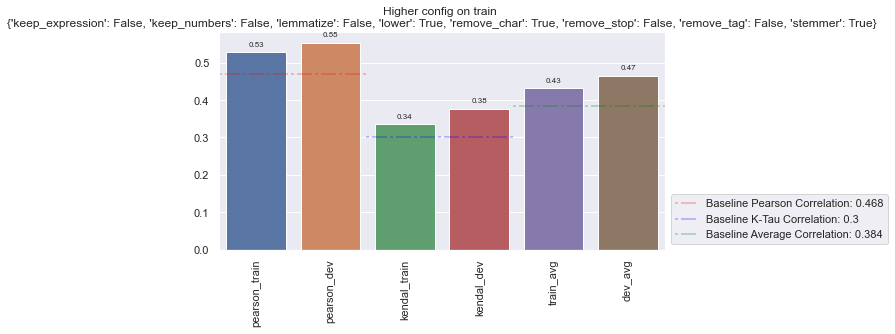

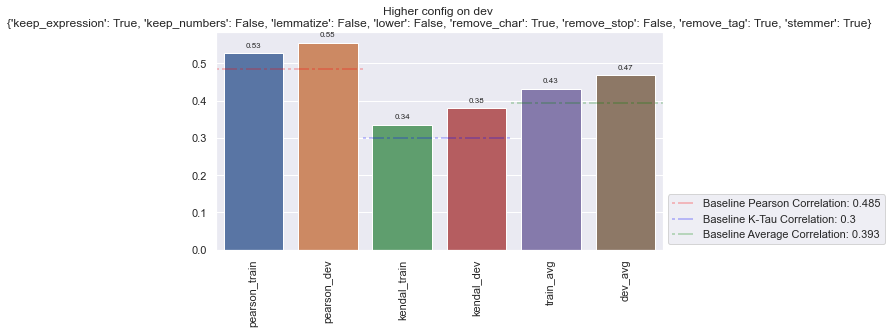

In [18]:
sns.set(rc={"figure.figsize":(8, 4)})

for data_type in ['train', 'dev']:
    col_list = ['pearson_train' ,'pearson_dev' ,'kendal_train' ,'kendal_dev' ,'train_avg' ,'dev_avg']
    fig = sns.barplot(finnishDf.sort_values(f'{data_type}_avg', ascending=False).iloc[0,8:][col_list].index,
                      finnishDf.sort_values(f'{data_type}_avg', ascending=False).iloc[0,8:][col_list].values)
    # Iterrating over the bars one-by-one
    for bar in fig.patches:
        fig.annotate(format(bar.get_height(), '.2f'), 
                       (bar.get_x() + bar.get_width() / 2, 
                        bar.get_height()), ha='center', va='center',
                       size=8, xytext=(0, 8),
                       textcoords='offset points')
    fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
    fig.set_title(f'Higher config on {data_type} \n' + str(dict(finnishDf.sort_values(f'{data_type}_avg', ascending=False).iloc[0, 0:8])))
    
    if data_type == 'train':
        
        baseline_pearson = 0.4683911953347246
        baseline_ktau = 0.300046314649797
        
    else:
        
        baseline_pearson = 0.4849728233340249
        baseline_ktau = 0.300046314649797
        
    avg = (baseline_pearson+baseline_ktau)/2
        
    line1 = plt.axhline(baseline_pearson, 0, 0.33, color = 'red', alpha = 0.3, label = f'Baseline Pearson Correlation: {round(baseline_pearson,3)}')
    line1.set_dashes([2, 2, 10, 2])
    
    line2 = plt.axhline(baseline_ktau, 0.33, 0.66, color = 'blue', alpha = 0.3, label = f'Baseline K-Tau Correlation: {round(baseline_ktau,3)}')
    line2.set_dashes([2, 2, 10, 2])
    
    line3 = plt.axhline(avg, 0.66, 1, color = 'green', alpha = 0.3, label = f'Baseline Average Correlation: {round(avg,3)}')
    line3.set_dashes([2, 2, 10, 2])
    
    plt.legend(bbox_to_anchor=(1,0), loc = 'lower left')
    plt.show()

In [19]:
parameters_ch = {'keep_numbers': [True, False],
                  'remove_punctuation': [True, False],
                  'remove_stop': [True, False],
                  'stopwords_set': ['merged', 'fst', 'snd']}

parameters_ch = pd.DataFrame(list(ParameterGrid(parameters_ch)))

In [ ]:
for conf in range(parameters_ch.shape[0]):
    sets = ['train', 'dev']
    cleaned_data = pd.DataFrame()
    cleaned_data['z-score'] = chinese['z-score']
    for column in ['reference', 'translation']:
        cleaned_data[column] = clean_ch(chinese[column],
                                    keep_numbers = parameters_ch.loc[conf, 'keep_numbers'],
                                    remove_punctuation = parameters_ch.loc[conf, 'remove_punctuation'],
                                    remove_stop = parameters_ch.loc[conf, 'remove_stop'],
                                    stopwords_set = parameters_ch.loc[conf, 'stopwords_set'])
    
    ch_train, ch_dev = train_test_split(cleaned_data, shuffle = True, test_size = 0.2, random_state = 7)
    ch_dev, ch_test = train_test_split(ch_dev, shuffle = True, test_size = 0.5, random_state = 7)
    
    ch_train_bl_encoded, ch_dev_bl_encoded, ch_test_bl_encoded = dataVectorization(ch_train, ch_dev, ch_test)
    
    y_train_label = np.array(ch_train['z-score'])
    chinese_train_pearson, chinese_train_kendalltau = getBaseline(ch_train_bl_encoded[0], ch_train_bl_encoded[1], y_train_label)
    parameters_ch.loc[conf, ['pearson_train', 'kendal_train']] = chinese_train_pearson[0], chinese_train_kendalltau[0]
    
    y_dev_label = np.array(ch_dev['z-score'])
    chinese_dev_pearson, chinese_dev_kendalltau = getBaseline(ch_dev_bl_encoded[0], ch_dev_bl_encoded[1], y_dev_label)
    parameters_ch.loc[conf, ['pearson_dev', 'kendal_dev']] = chinese_dev_pearson[0], chinese_dev_kendalltau[0]
    
parameters_ch.to_csv('grid_parameters_chinese.csv')

In [21]:
chineseDf = pd.read_csv('grid_parameters_chinese.csv', index_col = 0)

In [22]:
chineseDf['train_avg'] = (chineseDf['pearson_train'] + chineseDf['kendal_train']) / 2
chineseDf['dev_avg'] = (chineseDf['pearson_dev'] + chineseDf['kendal_dev']) / 2

In [23]:
chineseDf.sort_values(f'dev_avg', ascending=False).iloc[0:5,]

,keep_numbers,remove_punctuation,remove_stop,stopwords_set,pearson_train,kendal_train,pearson_dev,kendal_dev,train_avg,dev_avg
20,False,False,True,snd,0.383702,0.252836,0.417410,0.286903,0.318269,0.352156
14,False,True,True,snd,0.384114,0.252620,0.414883,0.286929,0.318367,0.350906
2,True,True,True,snd,0.385649,0.253712,0.415267,0.283750,0.319681,0.349509
8,True,False,True,snd,0.385485,0.254399,0.414134,0.284223,0.319942,0.349178
13,False,True,True,fst,0.371696,0.245661,0.412583,0.282217,0.308679,0.347400


In [ ]:
sns.set(rc={"figure.figsize":(8, 4)})

for data_type in ['train', 'dev']:
    col_list = ['pearson_train' ,'pearson_dev' ,'kendal_train' ,'kendal_dev' ,'train_avg' ,'dev_avg']
    fig = sns.barplot(chineseDf.sort_values(f'{data_type}_avg', ascending=False).iloc[0,4:][col_list].index,
                      chineseDf.sort_values(f'{data_type}_avg', ascending=False).iloc[0,4:][col_list].values)
    # Iterrating over the bars one-by-one
    for bar in fig.patches:
        fig.annotate(format(bar.get_height(), '.2f'), 
                       (bar.get_x() + bar.get_width() / 2, 
                        bar.get_height()), ha='center', va='center',
                       size=8, xytext=(0, 8),
                       textcoords='offset points')
    fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
    fig.set_title(f'Higher config on {data_type} \n' + str(dict(finnishDf.sort_values(f'{data_type}_avg', ascending=False).iloc[0, 0:8])))
    
    if data_type == 'train':
        
        baseline_pearson = 0.1473916639615326
        baseline_ktau = 0.12438157343879563
        
    else:
        
        baseline_pearson = 0.08052579663476413
        baseline_ktau = 0.12438157343879563
        
    avg = (baseline_pearson+baseline_ktau)/2
        
    line1 = plt.axhline(baseline_pearson, 0, 0.33, color = 'red', alpha = 0.3, label = f'Baseline Pearson Correlation: {round(baseline_pearson,3)}')
    line1.set_dashes([2, 2, 10, 2])
    
    line2 = plt.axhline(baseline_ktau, 0.33, 0.66, color = 'blue', alpha = 0.3, label = f'Baseline K-Tau Correlation: {round(baseline_ktau,3)}')
    line2.set_dashes([2, 2, 10, 2])
    
    line3 = plt.axhline(avg, 0.66, 1, color = 'green', alpha = 0.3, label = f'Baseline Average Correlation: {round(avg,3)}')
    line3.set_dashes([2, 2, 10, 2])
    
    plt.legend(bbox_to_anchor=(1,0), loc = 'lower left')
    plt.show()